### An introduction to Survival Analysis
**Quick implementation of Kaplan-Meier and Cox Proportional Hazard models on Telco Customer Churn dataset.**<br>
Objective : analyse the influence of some features on the churn of customers<br>
The dataset is available in Kaggle.

*References:* 
* Survival Analysis: Intuition & Implementation in Python, Anurag Pandey
* Lecture 15 Introduction to Survival Analysis BIOST 515, COLUMBIA UNIVERSITY


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%pylab inline
figsize(12,8)

Populating the interactive namespace from numpy and matplotlib


## Data Preprocessing

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [51]:
## Columns names
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [12]:
# check types of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [3]:
## Convert TotalCharges to numeric
# if invalid will return Nan so we should check if there any missing values later
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censored data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [15]:
# checking if there are any missing values
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [4]:
# filling the missing values
df['TotalCharges'].fillna(value=df.TotalCharges.median(),inplace=True)

In [21]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

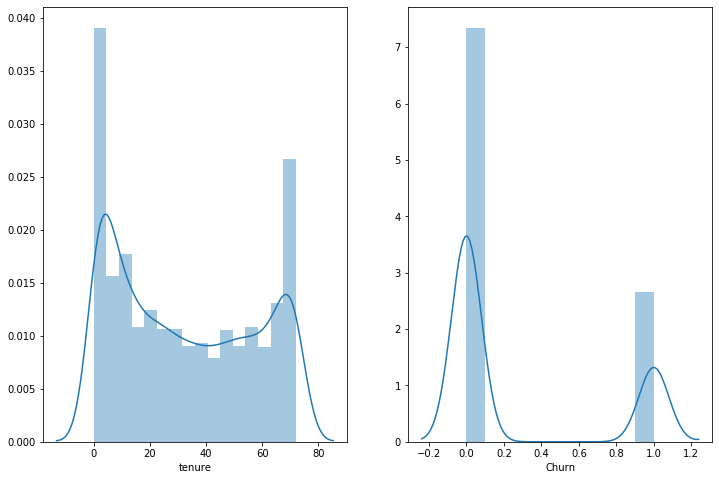

In [10]:
## Determining elements of interest ie time and event occurence
time = df['tenure']
event = df["Churn"]

# Plot histogram of distributions
plt.subplot(121)
sns.distplot(time)
plt.subplot(122)
sns.distplot(event)

## Features influence on churn and tenure of customers
Let's analyse the influence of some features on the churn rate of customers. We can assume a priori that only the following features would influence the churn rate: Charges(monthly or total), Contract, StreamingTV subscription, gender, senior citizenship. Moreover, there are many correlated features so it's important to drop them. We will assess the influence by estimating the kaplan-meier survival curves. Subsequently, we will quantify this influence by using the Cox-PH model.

### Influence of Monthly Charges on churn rate

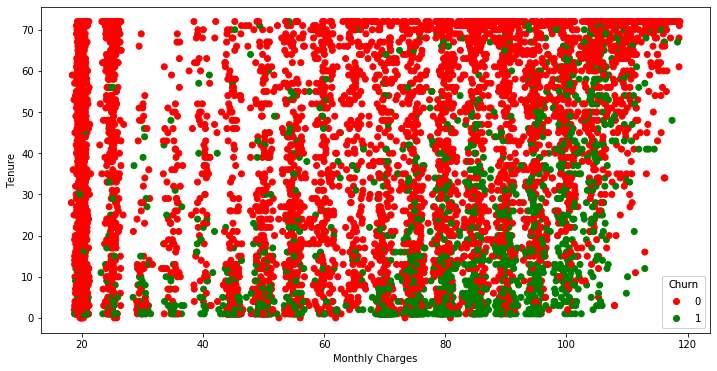

In [70]:
x = df.MonthlyCharges.values
y = df.tenure.values
label = df.Churn.values
colors = ['red','green']

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),loc="right left", title="Churn")
ax.add_artist(legend1)
ax.set_xlabel("Monthly Charges")
ax.set_ylabel("Tenure")
plt.show()

Churn is observed for high monthly charges.

## Kaplan-Meier Estimator

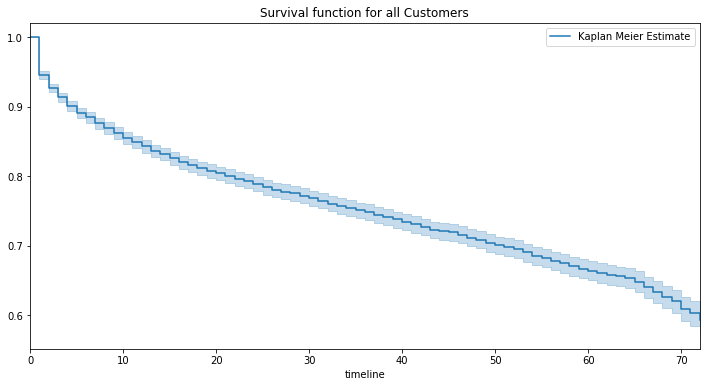

In [46]:
## Kaplan-Meier survival curves
km = lifelines.KaplanMeierFitter()
km.fit(time,event,label='Kaplan Meier Estimate')
km.plot(title="Survival function for all Customers")

### Influence of StreamingTv on tenure

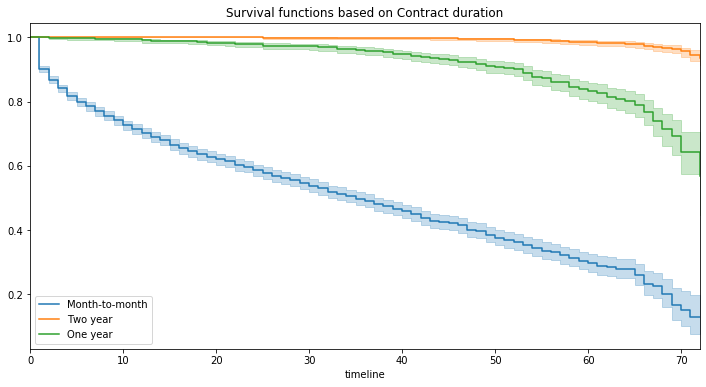

In [49]:
kmf = lifelines.KaplanMeierFitter() 


T = df['tenure']     ## time to event
E = df['Churn']      ## event occurred or censored


groups = df['Contract']             ## Create the groups from the 'Contract' column
ix1 = (groups == 'Month-to-month')   
ix2 = (groups == 'Two year')         
ix3 = (groups == 'One year')         


kmf.fit(T[ix1], E[ix1], label='Month-to-month')    ## fit the group1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Two year')         ## fit the group2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='One year')        ## fit the group3 data
kmf.plot(ax=ax1,title = 'Survival functions based on Contract duration')

### Influence of Senior citizenship on tenure

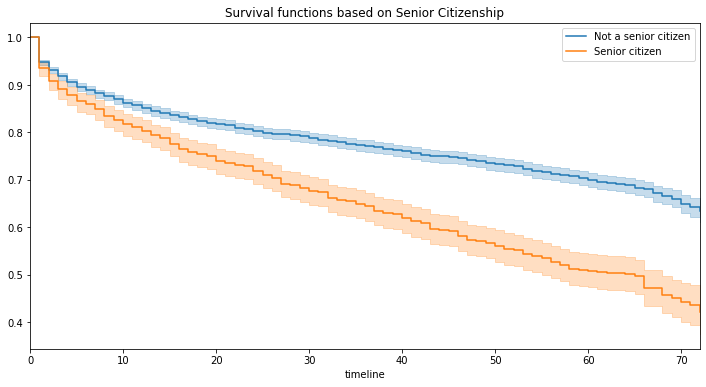

In [122]:
kmf1 = lifelines.KaplanMeierFitter() 


groups = df['SeniorCitizen']   
i1 = (groups == 0)       
i2 = (groups == 1)


## fit the model for 1st group
kmf1.fit(T[i1], E[i1], label='Not a senior citizen')
kmf1.plot()

## fit the model for 2nd group
kmf1.fit(T[i2], E[i2], label='Senior citizen')

kmf1.plot(title="Survival functions based on Senior Citizenship")


### Influence of StreamingTV on tenure

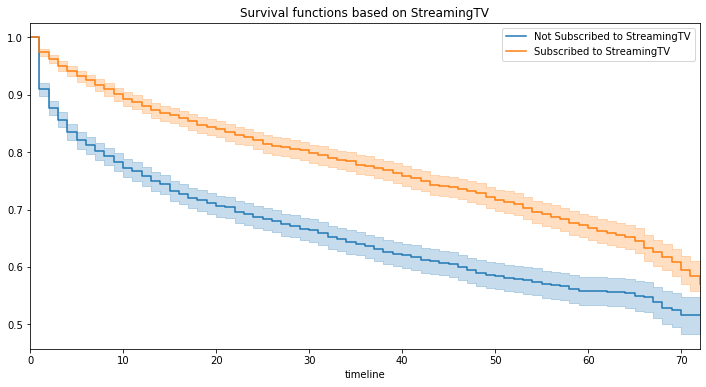

In [80]:
kmf1 = lifelines.KaplanMeierFitter() 


groups = df['StreamingTV']   
i1 = (groups == 'No')       
i2 = (groups == 'Yes')


kmf1.fit(T[i1], E[i1], label='Not Subscribed to StreamingTV')
a1 = kmf1.plot()
kmf1.fit(T[i2], E[i2], label='Subscribed to StreamingTV')
kmf1.plot(ax=a1,title="Survival functions based on StreamingTV")


### Tenure by gender

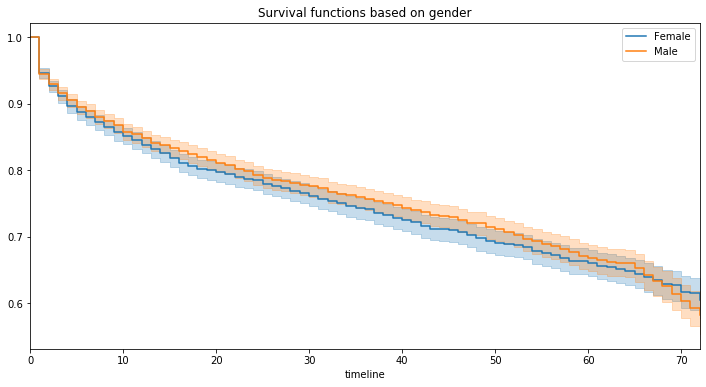

In [116]:
kmf1 = lifelines.KaplanMeierFitter() 


groups = df['gender']   
i1 = (groups == 'Female')       
i2 = (groups == 'Male')


kmf1.fit(T[i1], E[i1], label='Female')
a1 = kmf1.plot()
kmf1.fit(T[i2], E[i2], label='Male')
kmf1.plot(ax=a1,title="Survival functions based on gender")


## Cox-PH Estimator

In [113]:
df_cox = df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV','Contract']]
df_cox = pd.get_dummies(df_cox,drop_first=True)
df_cox.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes,Contract_One year,Contract_Two year
0,1,0,29.85,0,0,1,0,0,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0,1,0
2,2,1,53.85,0,1,0,0,1,0,0,0,0
3,45,0,42.30,0,1,0,0,0,0,0,1,0
4,2,1,70.70,0,0,0,0,1,0,0,0,0


In [114]:
cph = lifelines.CoxPHFitter()
cph.fit(df_cox, 'tenure', event_col='Churn')
cph.print_summary()

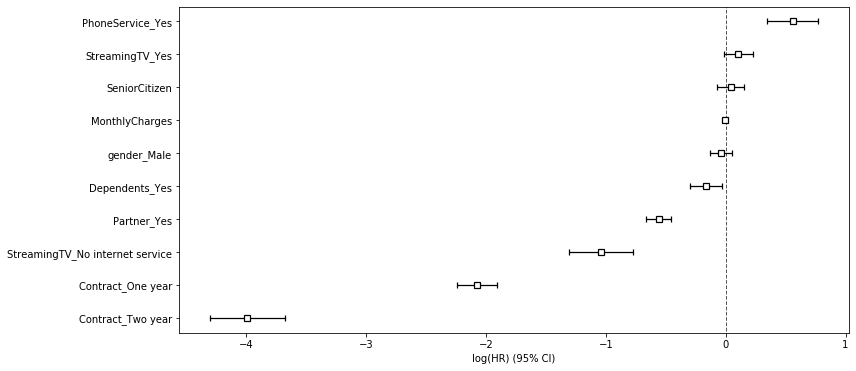

In [115]:
cph.plot()

### Compare predicted survival curves for different customers

As the Cox-PH is a non-parametric model, it isn't very relevant in our case to predict survival times for each individual. Actually, the baseline hazard function h_0 changes over time. It is the non parametric part of the model. However $h_0$ vanishes when we take the ratio of hazards between two customers. The hazard ratio measures which customer is more likely to churn and is constant over time.  
>$h(t|x_i)=h_0(t)exp(\beta x_i^T)$\
>$\frac{h(t|x_i)}{h(t|x_j)}=exp(\beta (x_i-x_j)^T)$

In [11]:
## Split the data into train_data and tests_data
df_train = df.iloc[:round(len(df)*0.85),:]
df_test = df.iloc[round(len(df)*0.85):len(df),:]

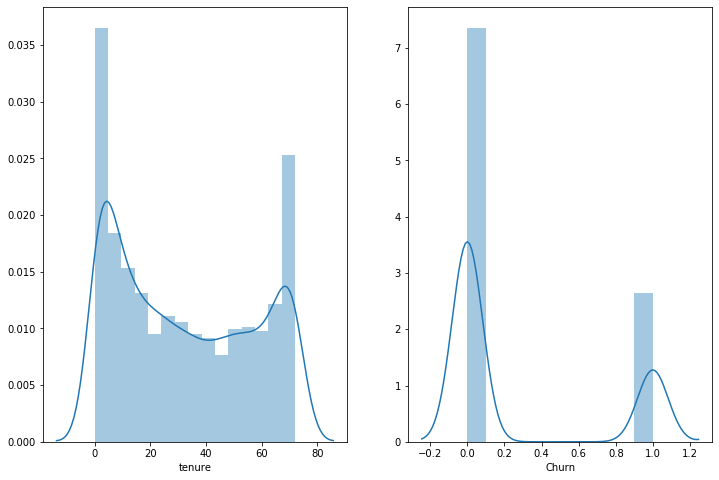

In [12]:
## Determining elements of interest ie time and event occurence
time_train = df_train['tenure']
event_train = df_train["Churn"]
time_test = df_test['tenure']
event_test = df_test["Churn"]

# Plot histogram of distributions
# To check if we have both censored and uncensored data in our training set (avoid bias)
plt.subplot(121)
sns.distplot(time_train)
plt.subplot(122)
sns.distplot(event_train)


In [14]:
df_cox = df_train.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV','Contract']]
df_cox = pd.get_dummies(df_cox,drop_first=True)
df_cox.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes,Contract_One year,Contract_Two year
0,1,0,29.85,0,0,1,0,0,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0,1,0
2,2,1,53.85,0,1,0,0,1,0,0,0,0
3,45,0,42.30,0,1,0,0,0,0,0,1,0
4,2,1,70.70,0,0,0,0,1,0,0,0,0


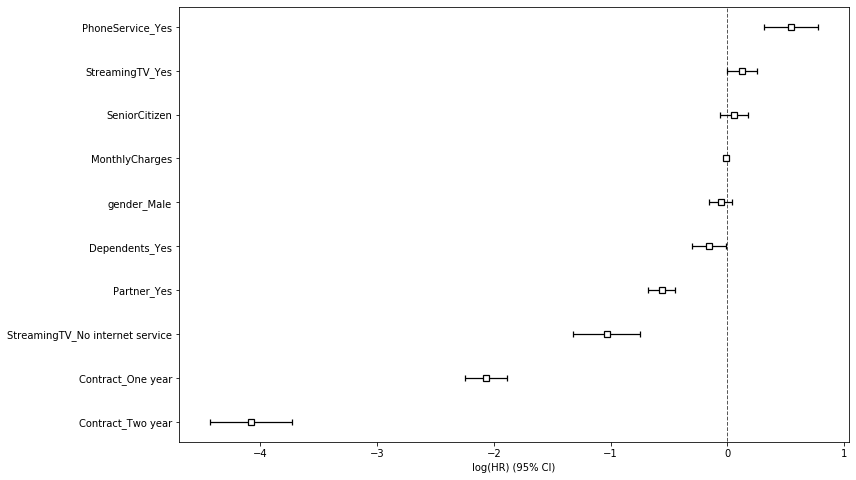

In [15]:
cph = lifelines.CoxPHFitter()
cph.fit(df_cox, 'tenure', event_col='Churn')
cph.plot()

A positive coefficient indicates a negative effect on the survival and a negative coefficient indicates a protective effect of the variable with which it is associated.

In [16]:
x_test = df_test.loc[:,['gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV','Contract']]
test_dummy = pd.get_dummies(x_test,drop_first=True)
#predictions = cph.predict_expectation(test_dummy).iloc[:,0]


In [18]:
test_dummy.head()

,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes,Contract_One year,Contract_Two year
5987,20.35,0,0,1,1,1,1,0,0,1
5988,21.05,0,1,1,1,1,1,0,0,1
5989,94.60,1,1,1,0,1,0,1,0,0
5990,94.70,0,1,0,1,1,0,1,0,0
5991,94.25,0,1,0,0,1,0,1,0,0


In [17]:
uncensored = df_test[df_test.Churn == 1].index
#uncensored_preds = predictions[uncensored]
#ind = uncensored_preds[uncensored_preds != inf].index
#y = df_test.tenure[ind]
#y_hat = predictions[ind]

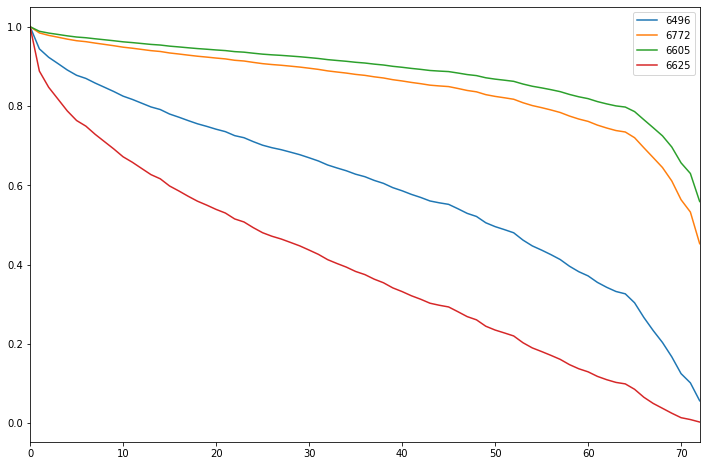

In [72]:
import random
l = random.sample(list(uncensored),4)
#plot the curves of 4 uncensored customers
cph.predict_survival_function(test_dummy.loc[l,:]).plot() 

In [75]:
for ind in l:
    print('Ground truth survival time of customer {} : {}'.format(ind,df_test.tenure[ind]))

Ground truth survival time of customer 6496 : 40
Ground truth survival time of customer 6772 : 38
Ground truth survival time of customer 6605 : 66
Ground truth survival time of customer 6625 : 12


In [95]:
pred = cph.predict_expectation(test_dummy.loc[l,:])
for ind in l:
    print('Predicted survival time of customer {} : {}'.format(ind,round(pred.loc[ind,0])))

Predicted survival time of customer 6496 : 43.0
Predicted survival time of customer 6772 : 61.0
Predicted survival time of customer 6605 : 64.0
Predicted survival time of customer 6625 : 28.0


The predicted tenure corresponds to the expectation of the survival curve. We can see that although some values are not quite close to the groundtruth, the risk ratios remain in the same order.